# Squeeze-and-Excitation Networks (SE-NET)


[reference](https://blog.csdn.net/u014380165/article/details/78006626)  
[Paper](https://arxiv.org/pdf/1709.01507.pdf)  
SE-NET 中文應該可以說是壓縮與激勵網路  
事實上並不是一個網路的架構，而是一種CNN模型應用的模組  
目的是將CNN的Channel賦予權重，讓重要的channel可以有較強的特徵萃取

![](https://imgur.com/2mODnab.png)

In [1]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization
from keras.layers import Input, GlobalAveragePooling2D, Concatenate, multiply, Reshape
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.optimizers import adam
from keras.utils import Sequence
from numpy.random import seed 
from tensorflow import set_random_seed 



seed_n = 67

random.seed(seed_n)
os.environ['PYTHONHASHSEED'] = str(seed)
seed(seed_n)
set_random_seed(seed_n)

Using TensorFlow backend.
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Dog vs Cat dataset

利用貓狗數據，自建一組naive的模型當作基準

training_parameter
* epoch = 15  
* optimizer = adam(lr = 0.0005)  
* batch_size = 32
* input_shape = (128,128,3)

In [2]:
ROOT_DIR = os.getcwd()
DATA_PATH = os.path.join(ROOT_DIR, "dogs-vs-cats")
SOURCE_DATA_DIR = os.path.join(DATA_PATH, "train")

print('length of train data %d' %(len(os.listdir(SOURCE_DATA_DIR))))

length of train data 25000


In [3]:
BASE_DIR = os.path.join(DATA_PATH, "VGG_Practice")
if not os.path.exists(BASE_DIR):
    os.mkdir(BASE_DIR)
    
TRAIN_DIR = os.path.join(BASE_DIR, "TRAIN")
if not os.path.exists(TRAIN_DIR):
    os.mkdir(TRAIN_DIR)
    
TEST_DIR = os.path.join(BASE_DIR, "TEST")
if not os.path.exists(TEST_DIR):
    os.mkdir(TEST_DIR)

VAL_DIR = os.path.join(BASE_DIR, "Validation")
if not os.path.exists(VAL_DIR):
    os.mkdir(VAL_DIR)
    
DOG_TRAIN = os.path.join(TRAIN_DIR, "DOG")
if not os.path.exists(DOG_TRAIN):
    os.mkdir(DOG_TRAIN)

CAT_TRAIN = os.path.join(TRAIN_DIR, "CAT")
if not os.path.exists(CAT_TRAIN):
    os.mkdir(CAT_TRAIN)
    
DOG_TEST = os.path.join(TEST_DIR, "DOG")
if not os.path.exists(DOG_TEST):
    os.mkdir(DOG_TEST)
    
CAT_TEST = os.path.join(TEST_DIR, "CAT")
if not os.path.exists(CAT_TEST):
    os.mkdir(CAT_TEST)

    
DOG_VAL = os.path.join(VAL_DIR, "DOG")
if not os.path.exists(DOG_VAL):
    os.mkdir(DOG_VAL)

CAT_VAL = os.path.join(VAL_DIR, "CAT")
if not os.path.exists(CAT_VAL):
    os.mkdir(CAT_VAL)

In [4]:
import shutil

for frame in ['cat.{}.jpg'.format(i) for i in range(0,9000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(CAT_TRAIN,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

for frame in ['dog.{}.jpg'.format(i) for i in range(0,9000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(DOG_TRAIN,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)
        
for frame in ['cat.{}.jpg'.format(i) for i in range(9001,11000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(CAT_TEST,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)
        
for frame in ['dog.{}.jpg'.format(i) for i in range(9001,11000)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(DOG_TEST,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

for frame in ['cat.{}.jpg'.format(i) for i in range(11001,12499)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(CAT_VAL,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

for frame in ['dog.{}.jpg'.format(i) for i in range(11001,12499)]:
    source = os.path.join(SOURCE_DATA_DIR,frame)
    target = os.path.join(DOG_VAL,frame)
    if not os.path.exists(target):
        shutil.copyfile(source,target)

In [5]:
dataset = './dogs-vs-cats/VGG_Practice/'

train_folder = dataset + 'TRAIN'
val_folder = dataset + 'Validation'
test_folder = dataset + 'TEST'

len(glob.glob(train_folder+'/*/*'))

18000

In [6]:
# normalizing
Imagegen = ImageDataGenerator(rescale=1./255)

batch_size = 32
train_datagen = Imagegen.flow_from_directory(
            train_folder,
            target_size=(128,128),
            batch_size=batch_size,
            class_mode='binary'
            )

validation_datagen = Imagegen.flow_from_directory(
            val_folder,
            target_size=(128,128),
            batch_size=batch_size,
            class_mode='binary'
            )

test_datagen = Imagegen.flow_from_directory(
            test_folder,
            target_size=(128,128),
            batch_size=128,
            class_mode='binary',
            shuffle=False
            )

for train_batch, label_batch in train_datagen:
    print('train_batch_shape: ', train_batch.shape)
    print('label_batch_shape: ', label_batch.shape)
    break;

Found 18000 images belonging to 2 classes.
Found 4996 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.
train_batch_shape:  (32, 128, 128, 3)
label_batch_shape:  (32,)


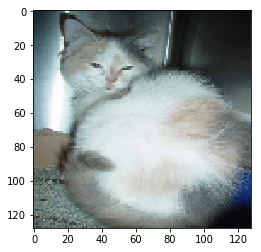

In [7]:
plt.imshow(train_datagen.next()[0][0])

In [8]:
units = 64

Input_L = Input(shape=(128,128,3))
x = Conv2D(units,(3,3),padding='same',activation='relu')(Input_L)
x = BatchNormalization()(x)
x = Conv2D(units,(3,3),padding='same',activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Conv2D(2*units,(3,3),padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(2*units,(3,3),padding='same',activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Conv2D(4*units,(3,3),padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(4*units,(3,3),padding='same',activation='relu')(x)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(8*units,activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(2*units,activation = 'relu')(x)
x = BatchNormalization()(x)
Output_L = Dense(1,activation = 'sigmoid')(x)

model = Model(Input_L,Output_L)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv

In [9]:
optimizer = adam(lr=0.0005)
model.compile(loss='binary_crossentropy',optimizer = optimizer, metrics = ['acc'])

In [10]:
model_callback = [callbacks.ModelCheckpoint("./dogs-vs-cats/naive_base.model",
                                           monitor='val_acc',
                                           mode = 'max',
                                           save_best_only=True,
                                           verbose=1)]

epochs=15
train_history = model.fit_generator(train_datagen,
                                    steps_per_epoch=train_datagen.samples/batch_size,
                                    epochs=epochs,
                                    validation_data=validation_datagen,
                                    validation_steps=validation_datagen.samples/batch_size,
                                    callbacks=model_callback,
                                    shuffle=False,
                                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
563/562 [==============================] - 100s 178ms/step - loss: 0.5462 - acc: 0.7238 - val_loss: 0.5897 - val_acc: 0.7266

Epoch 00001: val_acc improved from -inf to 0.72658, saving model to ./dogs-vs-cats/naive_base.model
Epoch 2/15
563/562 [==============================] - 92s 164ms/step - loss: 0.3911 - acc: 0.8229 - val_loss: 0.3517 - val_acc: 0.8411

Epoch 00002: val_acc improved from 0.72658 to 0.84107, saving model to ./dogs-vs-cats/naive_base.model
Epoch 3/15
563/562 [==============================] - 93s 165ms/step - loss: 0.2930 - acc: 0.8751 - val_loss: 0.3663 - val_acc: 0.8505

Epoch 00003: val_acc improved from 0.84107 to 0.85048, saving model to ./dogs-vs-cats/naive_base.model
Epoch 4/15
563/562 [==============================] - 93s 165ms/step - loss: 0.2091 - acc: 0.9152 - val_loss: 0.2384 - val_acc: 0.8955

Epoch 00004: val_acc improved from 0.85048 to 0.89552, saving model to ./dogs-vs-cats/naive_base.mode

In [11]:
def plot_train_result(train_history):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(train_history.history['loss']), plt.plot(train_history.history['val_loss'])
    plt.legend(['train','validation'])
    plt.title('loss_history')
    plt.xlabel('Epoch'), plt.ylabel('loss',fontsize=20)
    
    plt.subplot(1,2,2)
    plt.plot(train_history.history['acc']), plt.plot(train_history.history['val_acc'])
    plt.legend(['train','validation'])
    plt.title('acc_history')
    plt.xlabel('Epoch'), plt.ylabel('Acc',fontsize=20)
    plt.show()

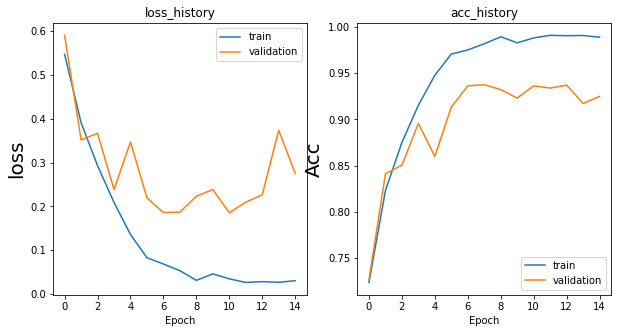

In [12]:
plot_train_result(train_history)

## Model2 -- apply SE block

SE-block首先將CNN輸出的圖形做GlobalAveragePooling2D  
其意義可視作為擷取整張圖的感受野  
在將其通過兩次的FC layer後用sigmoid輸出(投射0~1之間作為權重的輸出)  
在將權重乘回去CNN的channel
注意在FC layer中，其channel會先經過一次降維(減少channel數量，除以一個r值)，在第二的FC層還原成原本的channel數量  
圖為Inception& resnet網路的SEblock設計  
![](https://imgur.com/jvtkACv.png)  

這裡我的r取4，這是為了降低計算量，paper列出了降低的比例與結果，可以發現就算降低了複雜度，網路還是能夠得到足夠好的提升  
![](https://imgur.com/qBsdoxW.png)


In [13]:
def squeeze_excitation_layer(x, out_dim, ratio = 4):
    squeeze = GlobalAveragePooling2D()(x)
    excitation = Dense(units=out_dim // ratio, activation='relu')(squeeze)
    excitation = Dense(units=out_dim, activation='sigmoid')(excitation)
    excitation = Reshape((1,1,out_dim))(excitation)
    scale = multiply([x,excitation])
    return scale

In [14]:
units = 64

Input_L = Input(shape=(128,128,3))
x = Conv2D(units,(3,3),padding='same',activation='relu')(Input_L)
x = squeeze_excitation_layer(x, units)
x = BatchNormalization()(x)
x = Conv2D(units,(3,3),padding='same',activation='relu')(x)
x = squeeze_excitation_layer(x, units)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Conv2D(2*units,(3,3),padding='same',activation='relu')(x)
x = squeeze_excitation_layer(x, 2*units)
x = BatchNormalization()(x)
x = Conv2D(2*units,(3,3),padding='same',activation='relu')(x)
x = squeeze_excitation_layer(x, 2*units)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Conv2D(4*units,(3,3),padding='same',activation='relu')(x)
x = squeeze_excitation_layer(x, 4*units)
x = BatchNormalization()(x)
x = Conv2D(4*units,(3,3),padding='same',activation='relu')(x)
x = squeeze_excitation_layer(x, 4*units)
x = MaxPool2D()(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(8*units,activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(2*units,activation = 'relu')(x)
x = BatchNormalization()(x)
Output_L = Dense(1,activation = 'sigmoid')(x)

model2 = Model(Input_L,Output_L)

model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 64)           0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 16)           1040        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_5 (D

In [15]:
optimizer = adam(lr=0.0005)
model2.compile(loss='binary_crossentropy',optimizer = optimizer, metrics = ['acc'])

In [16]:
model_callback = [callbacks.ModelCheckpoint("./dogs-vs-cats/SE-naive_best.model",
                                           monitor='val_acc',
                                           mode = 'max',
                                           save_best_only=True,
                                           verbose=1)]

epochs=15
train_history = model2.fit_generator(train_datagen,
                                    steps_per_epoch=train_datagen.samples/batch_size,
                                    epochs=epochs,
                                    validation_data=validation_datagen,
                                    validation_steps=validation_datagen.samples/batch_size,
                                    callbacks=model_callback,
                                    shuffle=False,
                                    verbose=1)

Epoch 1/15
563/562 [==============================] - 123s 218ms/step - loss: 0.5642 - acc: 0.7073 - val_loss: 0.5767 - val_acc: 0.7220

Epoch 00001: val_acc improved from -inf to 0.72198, saving model to ./dogs-vs-cats/SE-naive_best.model
Epoch 2/15
563/562 [==============================] - 118s 210ms/step - loss: 0.4104 - acc: 0.8136 - val_loss: 0.5704 - val_acc: 0.7140

Epoch 00002: val_acc did not improve from 0.72198
Epoch 3/15
563/562 [==============================] - 119s 212ms/step - loss: 0.3074 - acc: 0.8660 - val_loss: 0.3049 - val_acc: 0.8685

Epoch 00003: val_acc improved from 0.72198 to 0.86849, saving model to ./dogs-vs-cats/SE-naive_best.model
Epoch 4/15
563/562 [==============================] - 148s 262ms/step - loss: 0.2134 - acc: 0.9120 - val_loss: 0.2437 - val_acc: 0.8977

Epoch 00004: val_acc improved from 0.86849 to 0.89772, saving model to ./dogs-vs-cats/SE-naive_best.model
Epoch 5/15
563/562 [==============================] - 119s 211ms/step - loss: 0.1377 - 

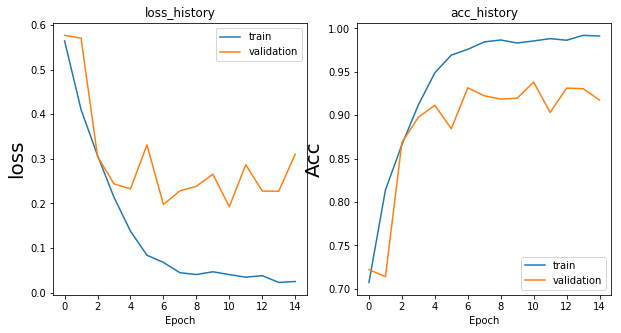

In [17]:
plot_train_result(train_history)

# Result

base model = 89.34  
SE-base model = 90.65

In [18]:
model_eval = load_model("./dogs-vs-cats/naive_best.model")
scores = model_eval.evaluate_generator(test_datagen,steps=len(test_datagen))
print('test data on naive_best accuracy: %.2f' %(scores[1]*100))

model_eval = load_model("./dogs-vs-cats/SE-naive_best.model")
scores = model_eval.evaluate_generator(test_datagen,steps=len(test_datagen))
print('test data accuracy on SE-naive_best model: %.2f' %(scores[1]*100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
test data on naive_best accuracy: 89.34
test data accuracy on SE-naive_best model: 90.65


## Summary  
Paper 提供了些成果比較如下

![](https://imgur.com/Eznnyw2.png)  
![](https://imgur.com/tozcuxi.png)